In [ ]:
!pip install bds_courseware

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA, TruncatedSVD 
import umap

from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS

%matplotlib inline
warnings.filterwarnings('ignore')

# Dataset description

Information in dataset is related to marketing campaign of banking institution. Campaign is considered successful if client subscribed a term deposit.
Bank data consists of input variables (both categorical and numerical) and output target variable with values 'yes' or 'no'.

All input variables can be divided into few groups:

   **Bank client data**
    
   1. age (numeric)
   2. job: type of job (categorical: "admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")
   3. marital: marital status (categorical: "divorced", "married", "single", "unknown")
   4. education (categorical: "basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")
   5. default: has credit in default? (categorical: "no", "yes", "unknown")
   6. housing: has housing loan? (categorical: "no", "yes", "unknown")
   7. loan: has personal loan? (categorical: "no", "yes", "unknown")

   **Related with the last contact of the current campaign**

   8. contact: contact communication type (categorical: "cellular", "telephone") 
   9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   10. day_of_week: last contact day of the week (categorical: "mon", "tue", "wed", "thu", "fri")
   11. duration: last contact duration, in seconds (numeric). Important note: this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
     
   **Other attributes**

   12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
   14. previous: number of contacts performed before this campaign and for this client (numeric)
   15. poutcome: outcome of the previous marketing campaign (categorical: "failure", "nonexistent", "success")
   
   **Social and economic context attributes**

   16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
   17. cons.price.idx: consumer price index - monthly indicator (numeric)     
   18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
   19. euribor3m: euribor 3 month rate - daily indicator (numeric)
   20. nr.employed: number of employees - quarterly indicator (numeric)

The goal of the project is to classify with high accuracy whether the campaign will be successful or not given a set of input variables.

In [ ]:
# Read in the data
name = "bank"
data = read_drive_dataset(*HOMEWORK_DATASETS[name])

# Exploratory Data Analysis

Basic EDA will be done to check features of data set.
In our dataset we have both numerical and categorical features, target variable Y has binary nature.
Let's start with some general information like duplicates and statistical summary. 

In [ ]:
# Checking for duplicated records
data[data.duplicated(keep='last')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20072,55,services,married,high.school,unknown,no,no,cellular,aug,mon,33,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20531,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25183,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,114,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [ ]:
# Deleting duplicated records
data = data.drop_duplicates()

In [ ]:
# General statistics overview
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


* From statistical summary we can see that most probably there are ouliers for age, duration and campaign numerical features
* pdays and previous have most of data concentrated around one value.

## 1. Univariate analysis

### 1.1. Target 
Let's check what we have for Y variable

Text(0.5, 1.0, 'Y distribution')

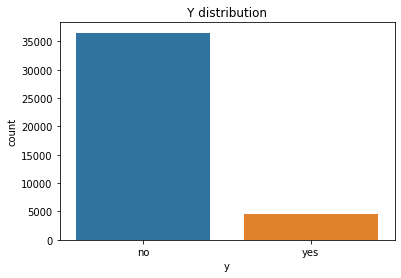

In [ ]:
# Visualizing target variable y distribution
sns.countplot(x='y', data=data)
plt.title("Y distribution")

In [ ]:
# Calculating percentage of 'no' and 'yes' values of target
data.y.value_counts(True)

no     0.887337
yes    0.112663
Name: y, dtype: float64

We can see that most of answers are 'no' and data is very imbalanced.

Next will check categorical features, but before will create some functions for faster plotting. 

In [ ]:
# Helper function for complex plotting
def plot1(column, ax):
    sns.countplot(x = column, data = data, ax = ax)
    ax.set_xlabel(column.title())
    ax.set_ylabel("Count")
    ax.set_title(f'{column.title()} Count')
    
# Function for 4 plots visualization
def plot4(column1, column2, column3, column4):
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 12))
    
    plot1(column1, ax1)
    plot1(column2, ax2)
    plot1(column3, ax3)
    plot1(column4, ax4)
    
# Function for 2 plots visualization with long values names    
def plot2_l(column1, column2):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    
    plot1(column1, ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 70)
    
    plot1(column2, ax2)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 70)

### 1.2. Categorical features: marital, default, housing, loan

Visualization of distributions for those features

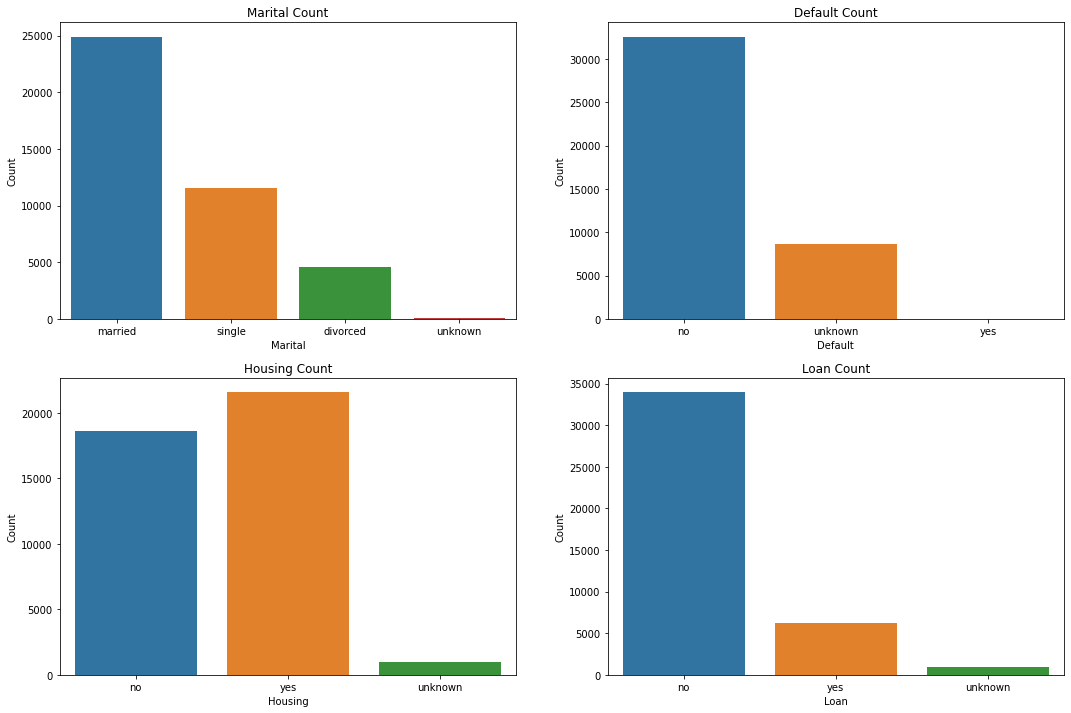

In [ ]:
plot4('marital', 'default', 'housing', 'loan')

* Here we can see that most respondents are married, don't have personal loan and mostly have housing loan.
* For marital, housing and loan 'unknown' values are very small, so I'll replace them with most frequent value in next section.
* Now let's check default for percentage of 'unknown' and may be even drop this feature.

In [ ]:
data.default.value_counts(True)

no         0.791165
unknown    0.208762
yes        0.000073
Name: default, dtype: float64

In [ ]:
# Dropping default as it has more then 20% value 'unknown' and known values are mostly 'no'
data.drop('default', axis=1, inplace=True)

### 1.3. Categorical features: contact, month, day_of_week, poutcome
Visualization of distributions for those features

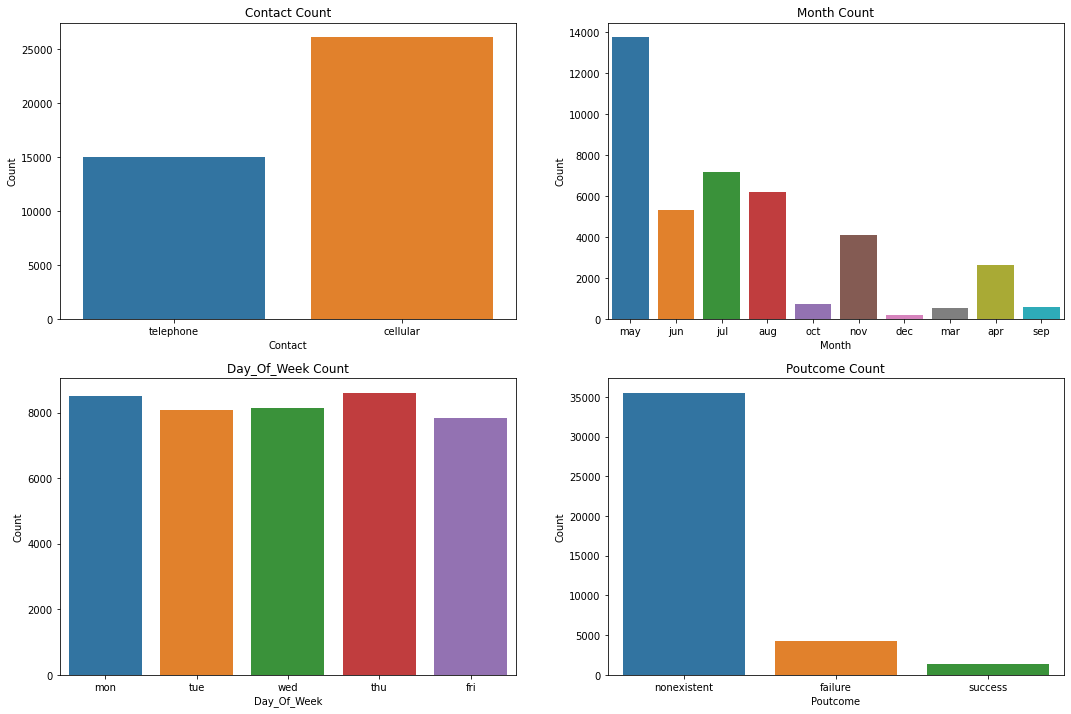

In [ ]:
plot4('contact', 'month', 'day_of_week', 'poutcome')

* Looks like cellular method of contact is most frequently used and May plus Summer months have the biggest amount of responses.
* Distribution of day of week is almost uniform. 
* And previous outcome feature contains big part od 'nonexistent' value which is actually very close to 'unknown' and that's why will not give us any useful information. So we can drop this feature.

In [ ]:
# Dropping poutcome feature
data.drop('poutcome', axis=1, inplace=True)

### 1.4. Categorical features: job, education
Visualization of distributions for those features

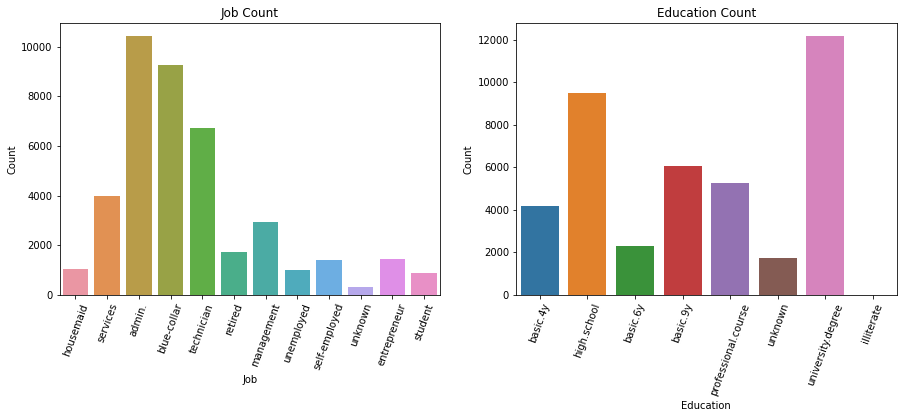

In [ ]:
plot2_l('job', 'education')

* We can see that most of respondents work as admins, blue-collars or technicians.
* Most of them have university.degree or high.school education.
* Unknown values for both distributions are pretty small and can be replaced with most frequent value.

### 1.5. Numerical features: age, duration, campaign

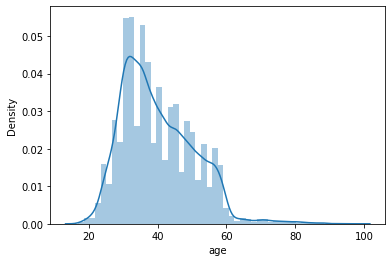

In [ ]:
# Visualization for age distribution
sns.distplot(data.age)

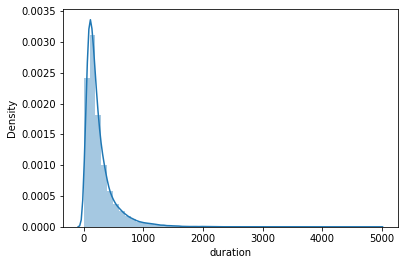

In [ ]:
# Visualization for duration distribution
sns.distplot(data.duration)

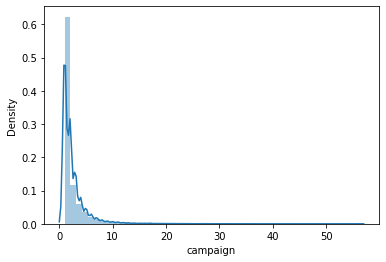

In [ ]:
# Visualization for campaign distribution
sns.distplot(data.campaign)

In [ ]:
# Statistics for age, duration and campaign
data[['age', 'duration', 'campaign']].describe()

,age,duration,campaign
count,41176.00000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879
std,10.42068,259.305321,2.770318
min,17.00000,0.000000,1.000000
25%,32.00000,102.000000,1.000000
50%,38.00000,180.000000,2.000000
75%,47.00000,319.000000,3.000000
max,98.00000,4918.000000,56.000000


In [ ]:
# Skewness for age, duration and campaign
data[['age', 'duration', 'campaign']].skew()

age         0.784560
duration    3.262808
campaign    4.762044
dtype: float64

* For age most of respondents have 32-47 years old.
* Most often duration of call is between 102 and 319 seconds. 
* Most often 1-3 contacts performed during this campaign for 1 person.
* Duration and campaign features have very high skewness.
* We have outliers for those 3 features, they will be handled later.

### 1.6. Numerical features: pdays, previous

From statistics for those features we can see that most of data for pdays and previous are within one value. We will check visualization to decide about dropping those features.

In [ ]:
# Statistics for pday and previous
data[['pdays', 'previous']].describe()

,pdays,previous
count,41176.000000,41176.000000
mean,962.464810,0.173013
std,186.937102,0.494964
min,0.000000,0.000000
25%,999.000000,0.000000
50%,999.000000,0.000000
75%,999.000000,0.000000
max,999.000000,7.000000


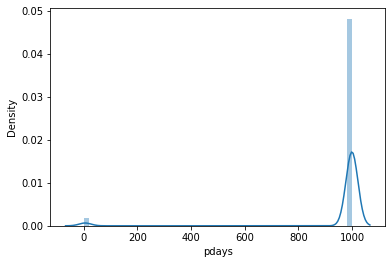

In [ ]:
# Visualization for pdays
sns.distplot(data.pdays)

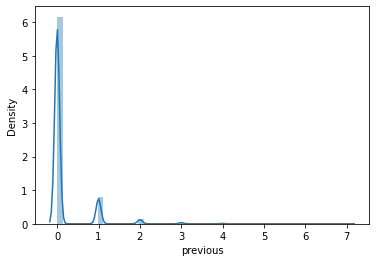

In [ ]:
# Visualization for previous
sns.distplot(data.previous)

In [ ]:
# Calculating percentage of most frequent value for pdays and previous
print(data.pdays.value_counts(True).head(2))
print(data.previous.value_counts(True).head(2))

999    0.963207
3      0.010662
Name: pdays, dtype: float64
0    0.863391
1    0.110768
Name: previous, dtype: float64


* We can see that for pdays 96% of data are with value 999.
* For previous 0 value has 86% of data.
* We can remove pdays and previous features as not informative for target variable.

In [ ]:
# Dropping previous and pdays features
data.drop('previous', axis=1, inplace=True)
data.drop('pdays', axis=1, inplace=True)

### 1.7. Numerical features: emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Those features have economic context, so better to check them in relation to target also.

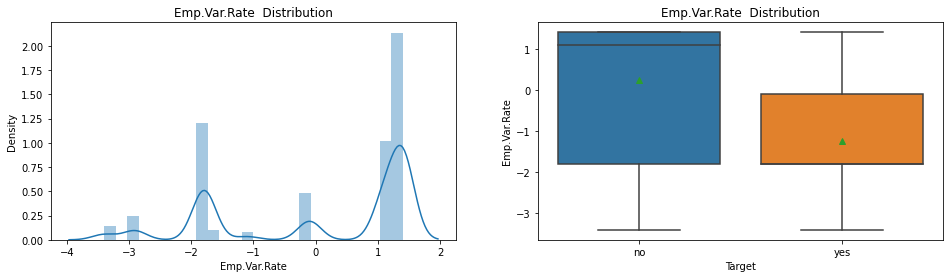

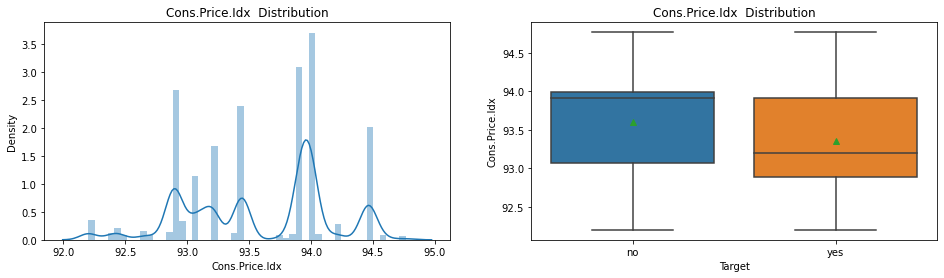

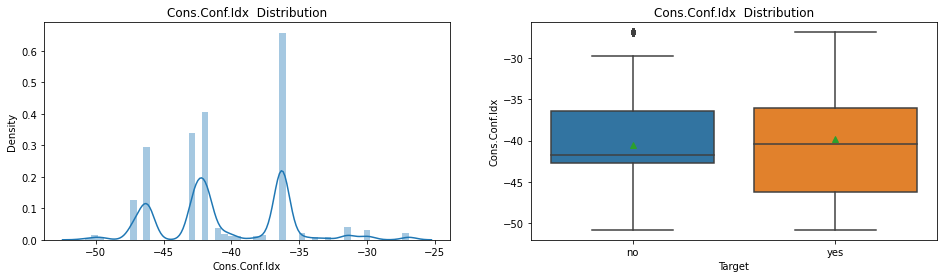

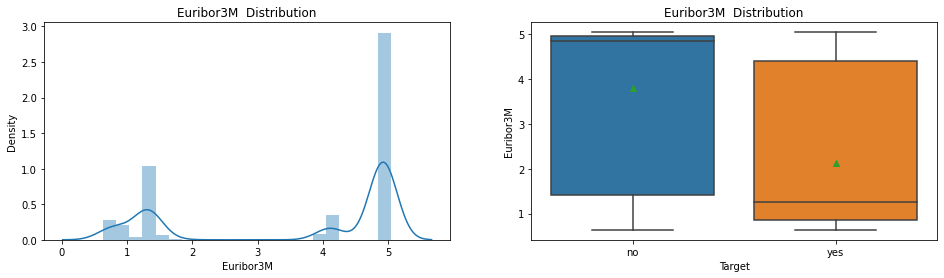

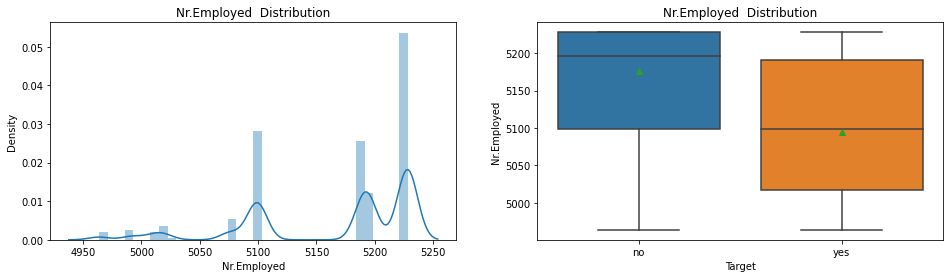

In [ ]:
# Visualization for economical features separately and with target variable
econ_columns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

for column in econ_columns:

    plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    sns.distplot(data[column])
    plt.xlabel(column.title())
    plt.ylabel('Density')
    plt.title(f'{column.title()}  Distribution')

    plt.subplot(1,2,2)
    sns.boxplot(x='y', y=column, data =data, showmeans=True )
    plt.xlabel('Target')
    plt.ylabel(column.title())
    plt.title(f'{column.title()}  Distribution')

In [ ]:
# Statistics for economical features
data[['emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed']].describe()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,1.570883,0.578839,4.627860,1.734437,72.251364
min,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,1.400000,94.767000,-26.900000,5.045000,5228.100000


* All economical features have not normal data distributions, but they are pretty similar to each other
* There are some not very extreme outliers for cons.conf.idx, but we can don't change them as this feature have not very big influence on target
* 4 from economical features (emp.var.rate, cons.price.idx, euribor3m, nr.employed) have visible impact on target variable and can be very useful for future modeling

## 2. Multivariate analysis



### 2.1. Categorical features vs target relations

In [ ]:
# Function for 2 plots visualisation with target relation
def plot2_h(column1, column2):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

    sns.countplot(x = column1, data = data, ax = ax1, hue='y')
    ax1.set_title(f'{column1.title()} distribution', fontsize = 13)
    ax1.set_xlabel(column1, fontsize = 12)
    ax1.set_ylabel("Count", fontsize = 12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 70)

    sns.countplot(x = column2, data = data, ax = ax2, hue='y')
    ax2.set_title(f'{column2.title()} distribution', fontsize = 13)
    ax2.set_xlabel(column2, fontsize = 12)
    ax2.set_ylabel("Count", fontsize = 12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 70)

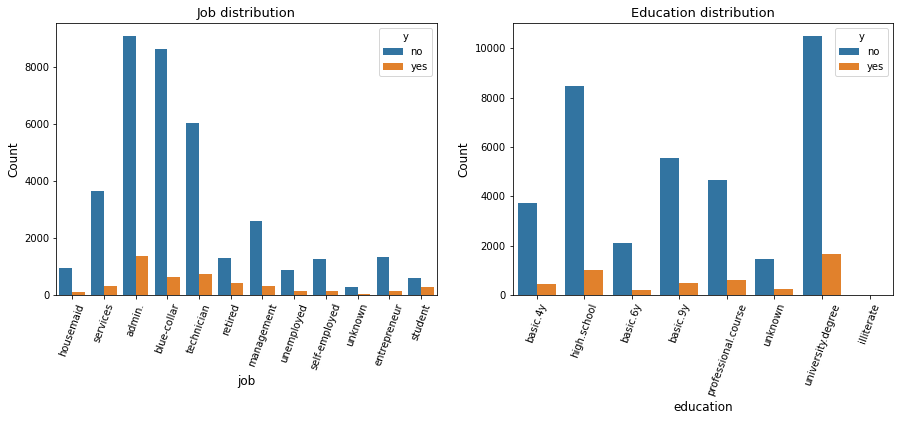

In [ ]:
# Visualization for job/education vs target
plot2_h('job', 'education')

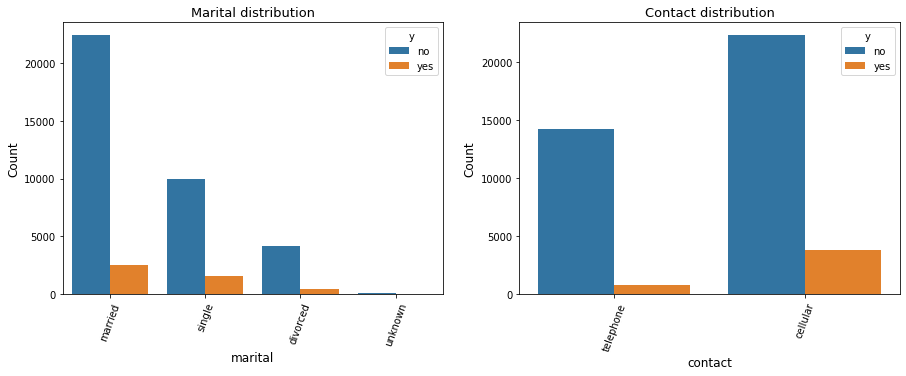

In [ ]:
# Visualization for marital/contact vs target
plot2_h('marital', 'contact')

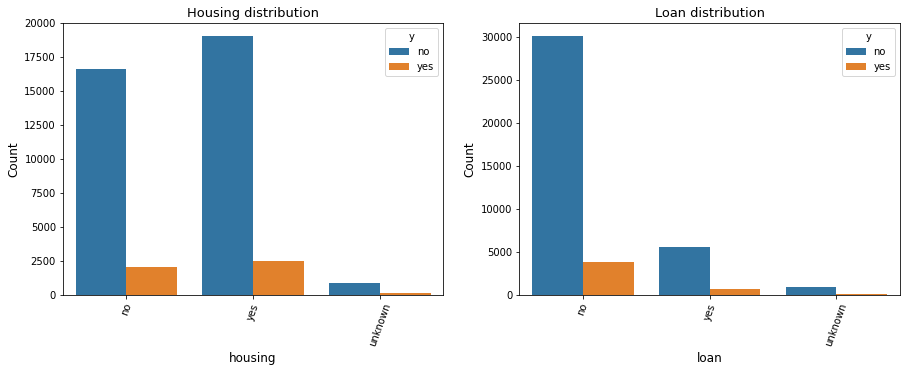

In [ ]:
# Visualization for housing/loan vs target
plot2_h('housing', 'loan')

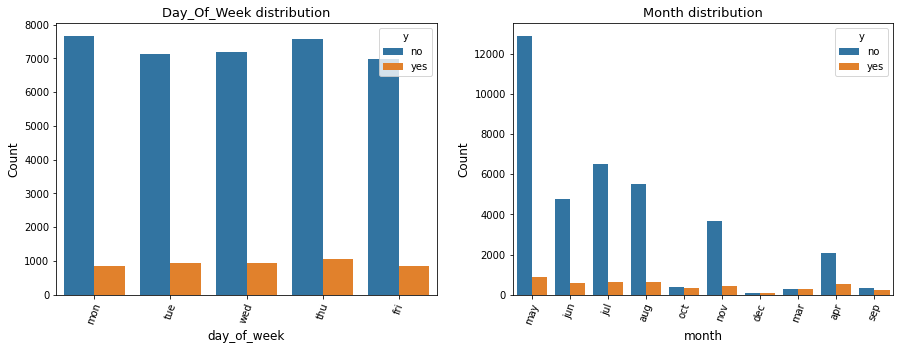

In [ ]:
# Visualization for day_of_week/month vs target
plot2_h('day_of_week', 'month')

* We can see that both 'yes' or 'no' values of target are represented in every value for categorical variables
* For day_of_week there is no difference in days for target variable,relation of no/yes is the same every day. So this feature can be dropped.
* For loan feature we have most of answers 'no' and also there is no big difference due to target relation. So this feature also can be dropped. 

In [ ]:
# Dropping day_of_week and loan
data.drop('day_of_week', axis=1, inplace=True)
data.drop('loan', axis=1, inplace=True)

### 2.2. Categorical vs numerical features relations

Text(0.5, 1.0, 'Age vs Education')

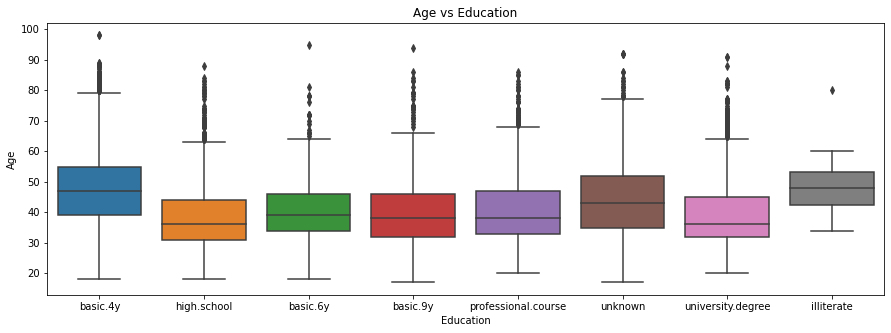

In [ ]:
# Visualization for age and education relations
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "education", y = "age", data = data, orient = 'v')
ax.set_xlabel("Education")
ax.set_ylabel("Age")
ax.set_title("Age vs Education")

* We can see that clients with basic.4y education or illiterate have more then 40-50 years
* Other types of education have people with lower age, 30-45 years

Text(0.5, 1.0, 'log(Duration) vs Jobs')

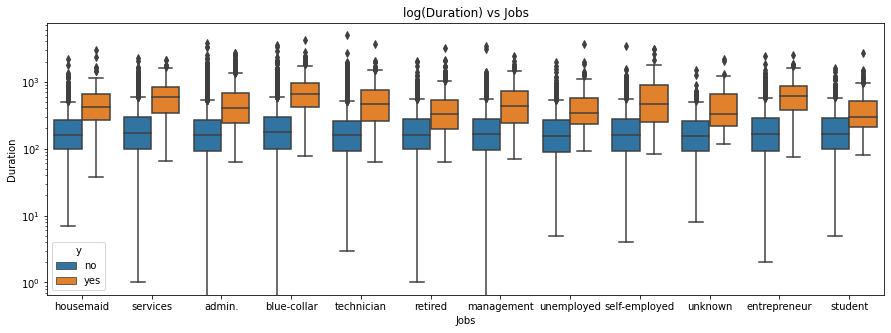

In [ ]:
# Visualization for job and duration of call relations with introduced target variable 
# log scale was added to duration axis to improve visibility
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = "job", y = "duration", data = data, orient = 'v', hue='y')
ax.set_xlabel("Jobs")
ax.set_ylabel("Duration")
ax.set_yscale("log")
ax.set_title("log(Duration) vs Jobs")

* Looks like there is no big difference in call duration for some particular job
* For target 'yes' value duration is obviously higher

### 2.3. Numerical features relations

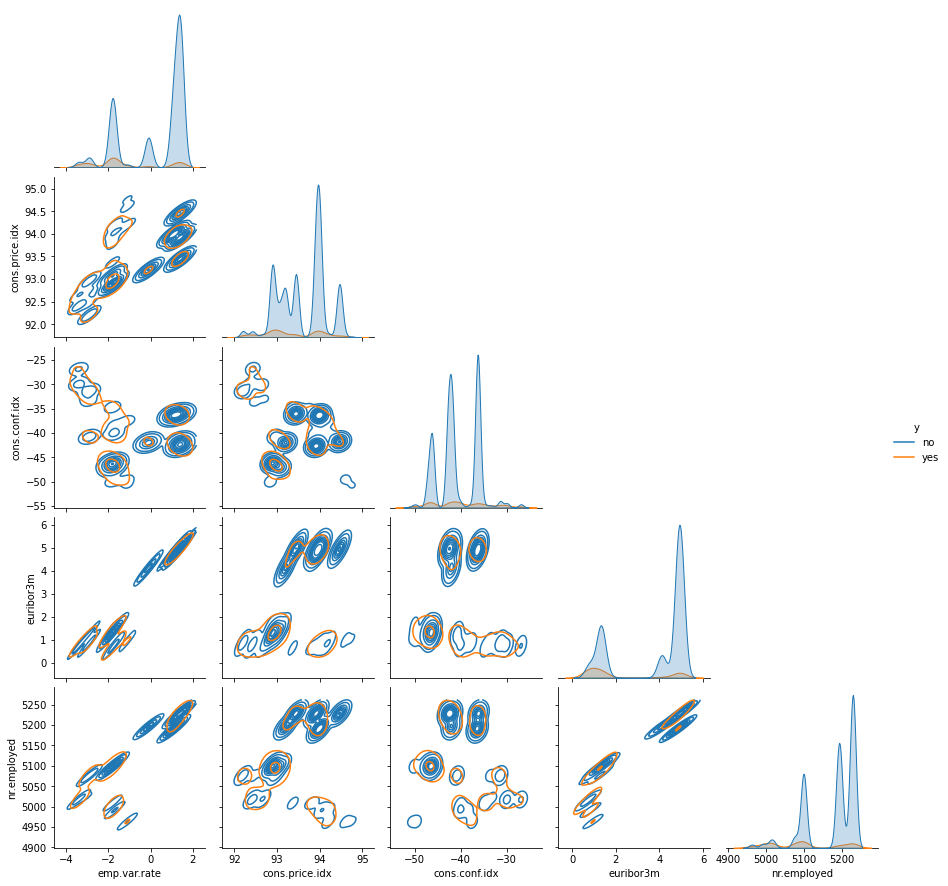

In [ ]:
# Visualisation relations between economical features with introduced target
sns.pairplot(
    data,
    x_vars=econ_columns,
    y_vars=econ_columns,
    hue='y',
    corner=True,
    kind="kde"
)

* From pairplot we can see that there is visible correlation between:
  1. **euribor3m** vs **nr.employed**
  2. **euribor3m** vs **emp.var.rate**
  3. **emp.var.rate** vs **nr.employed**
  4. **emp.var.rate** vs **cons.price.idx**
  
  
* To check correlation between target variable and numerical features we can use a point-biseral correlation. For this we will change target to binary 0 and 1 values. Calculations are the same as for Pearson's correlation.

In [ ]:
# Changing target categorical value Y to binary 
data.y = data.y.apply(lambda x: 0 if x=='no' else 1)
data.y.unique()

array([0, 1])

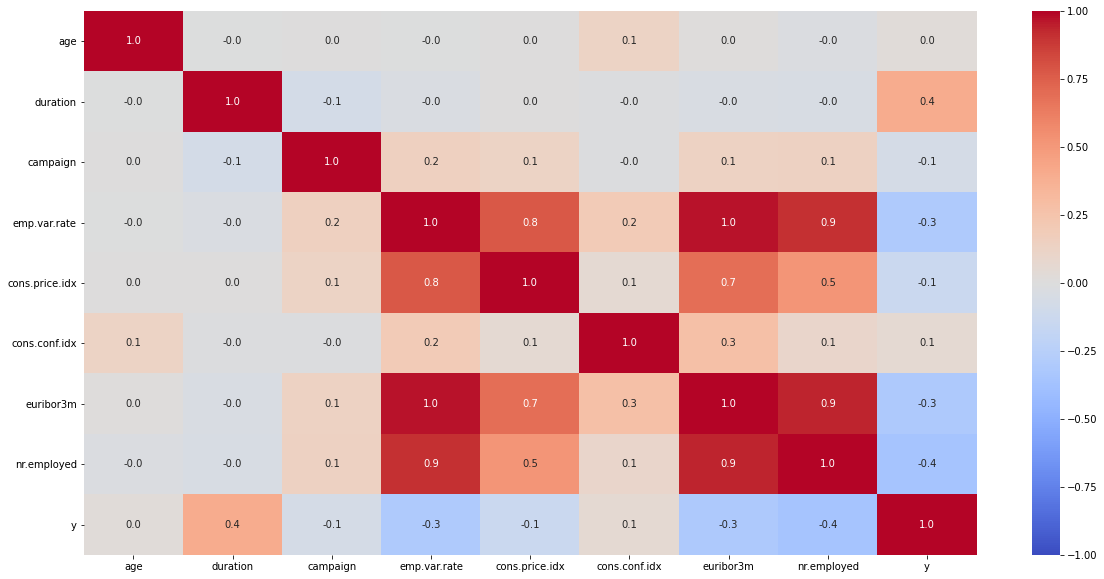

In [ ]:
# Generate correlation matrix heat map to check which numerical feature has greatest influence on the target 
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(data.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm')

In [ ]:
data.corr().y.sort_values()

nr.employed      -0.354669
euribor3m        -0.307740
emp.var.rate     -0.298289
cons.price.idx   -0.136134
campaign         -0.066361
age               0.030381
cons.conf.idx     0.054802
duration          0.405297
y                 1.000000
Name: y, dtype: float64

* Target has a moderate correlation with **duration, nr.employed, euribor3m** and **emp.var.rate.**
Therefore they might form a very good features compared to others. 
* Also we should note that emp.var.rate has a strong correlation with nr.employed, euribor3m and cons.price.idx. So we need to avoid multicolinearity while selecting our features.

# Data Preparation

## 1. Missing values
There is no missing values in our dataset, but we have 'unknown' values for some categorical features, which is actually the same as missing

In [ ]:
# Replacing 'unknown' with nan
data.replace('unknown', np.nan, inplace=True)

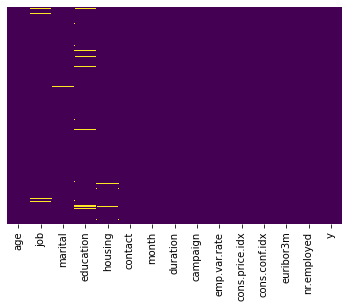

In [ ]:
# Visualization of 'unknown' values
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [ ]:
# Percentage of missing values for each feature
data.isna().sum()/len(data)

age               0.000000
job               0.008014
marital           0.001943
education         0.042015
housing           0.024043
contact           0.000000
month             0.000000
duration          0.000000
campaign          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
y                 0.000000
dtype: float64

* We can see that there is very small amount of missing values in dataset
* They all are for categorical features with small impact on target variable
* That's why they can be replaced with most frequent value as the best strategy in this case. Will be done in pipeline

In [ ]:
# Creating instance of SimpleImputer which will be used in pipeline
sim_im = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent',
    verbose=1
)

## 2. Outliers
As we remember from univariate analysis there are outliers for age, duration and campaign. For dropping them we select method with 1.5(IQR) as it deletes extreme values, but still left pretty much rows which can be useful for other features.

In [ ]:
# Statistics for age, duration and campaign
data[['age', 'duration', 'campaign']].describe()

,age,duration,campaign
count,41176.00000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879
std,10.42068,259.305321,2.770318
min,17.00000,0.000000,1.000000
25%,32.00000,102.000000,1.000000
50%,38.00000,180.000000,2.000000
75%,47.00000,319.000000,3.000000
max,98.00000,4918.000000,56.000000


In [ ]:
# Function for deleting rows with outliers
def drop_outliers(df, column):
    Q1, Q3 = np.percentile(column,[25,75])
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5*IQR)
    upper_limit = Q3 + (1.5*IQR)
    df.drop(df[column<lower_limit].index, inplace=True)
    df.drop(df[column>upper_limit].index, inplace=True)
    print('Outliers deleted')

In [ ]:
# Deleting outliers for age, duration and campaign
drop_outliers(data, data.age)
drop_outliers(data, data.duration)
drop_outliers(data, data.campaign)

Outliers deleted
Outliers deleted
Outliers deleted


## 3. Categorical data preparation
To prepare categorical data we will use OneHotEncoder as it is easy and applicable to our categorical data. Despite some categorical values like education have some ordinal nature it is still hard to understand exact order of all education values. So using OneHotEncoder is more safe in this case.

In [ ]:
# Creating instance of OneHotEncoder which will be used in pipeline
ohe = OneHotEncoder(sparse=False)

## 4. Pipeline

In [ ]:
# Separating numerical and categorical features and deleting target
numerical_features = data.select_dtypes('number').columns
categorical_features = data.select_dtypes(np.object).columns
categorical_features = np.delete(categorical_features, -1)

In [ ]:
# Creating instance of StandardScaler which will be used in pipeline
sc = StandardScaler()

In [ ]:
# Pipeline and ColumnTransformer instances
num_pipe = Pipeline([
    ('scaler', sc),
    ('variance_trsh', VarianceThreshold(threshold=0.01))
])

cat_pipe = Pipeline([
    ('imputer', sim_im),
    ('ohe', ohe), 
    ('variance_trsh', VarianceThreshold(threshold=.9 * (1 - .9)))
])

pipe = ColumnTransformer(transformers=[
    ('cat', cat_pipe, categorical_features),
    ('num', num_pipe, numerical_features)
])

In [ ]:
# Changing input data
X = pipe.fit_transform(data)

In [ ]:
X.shape

(35524, 23)

# Dimensionality reduction

## 1. Principal Component Analysis technique

In [ ]:
# Applying PCA for dimentionality reduction
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

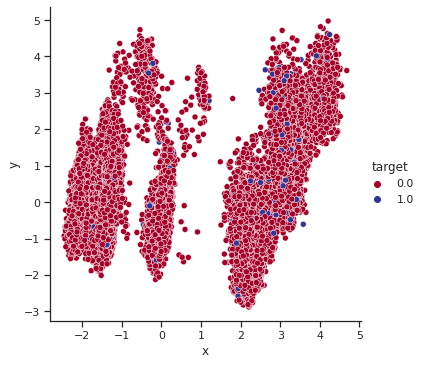

In [ ]:
# Visualization for PCA
plot_data = pd.DataFrame.from_records(data=new_X[:,:2],columns=["x","y"])
plot_data["target"] = data['y']

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_data, hue="target", palette='RdYlBu')

In [ ]:
# Calculating explained variance for PCA
pca.explained_variance_ratio_.sum()

0.43400844041453823

In [ ]:
# Selecting the best number of components with PCA
pca = PCA(n_components=0.95).fit(X)
len(pca.explained_variance_ratio_)

13

* As we can see feature reduction is pretty big from 23 to 13 features
* Explained variance for them is 43% which is not very big, but it can be improved for more balanced target. Also as we saw from correlation matrix that there is not a lot of features which have at least moderate correlation with target.

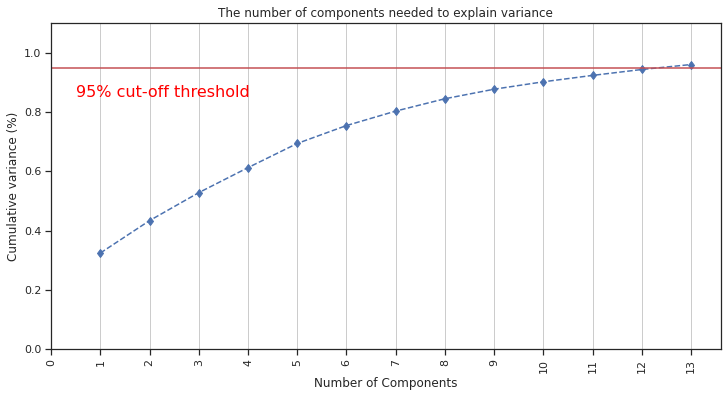

In [ ]:
# Visualization for selecting the best number of components with PCA
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='d', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

## 2. Singular Value Decomposition technique

In [ ]:
# Applying PCA for dimentionality reduction
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_X = svd.fit_transform(X)

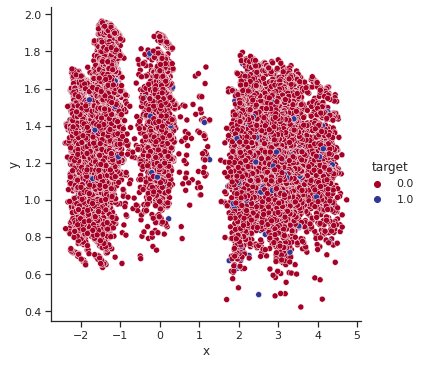

In [ ]:
# Visualization for SVD
plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["target"] = data['y']

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='RdYlBu')

In [ ]:
# Calculating explained variance for PCA
svd.explained_variance_ratio_.sum()

0.3295015627963686

* For SVD technique explained variance is even smaller so for this dataset PCA is better for dimensionality reduction.

## 3. Uniform Manifold Approximation and Projection technique

In [ ]:
# Applying UMAP for dimentionality reduction
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.15).fit_transform(X)

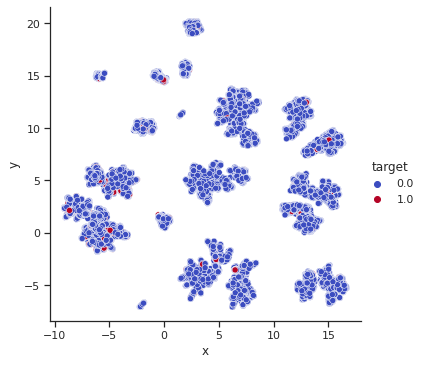

In [ ]:
# Visualization for UMAP
plot_df = pd.DataFrame.from_records(data=embedding,columns=["x","y"])
plot_df["target"] = data['y']

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

* Looks like UMAP works very good for dimetionality reduction but dataset is still imbalanced regarding target variable. 
* Improvements needed.

# Conclusions

1. We have few features in our dataset which can explaine about 43% of variability for target value.
2. There are still a lot of features which don't have any impact on target and mostly they are categorical.
3. We can use PCA or UMAP technique for dimensionality reduction but we need to balance our dataset.
4. Additional information needed about duration feature as it has impact on target value but still not clear if it is possible to use it for analysis.